
Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os, sys
import copy


# plt.ion()   # interactive mode

In [2]:
sys.version

'3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:22:33) [MSC v.1916 64 bit (AMD64)]'

In [3]:
print('torch.cuda.is_available() --> ', torch.cuda.is_available())
# print(torch.cuda.memory_summary())
print(torch.cuda.get_device_properties(0))

torch.cuda.is_available() -->  True
_CudaDeviceProperties(name='GeForce GTX 1060', major=6, minor=1, total_memory=6144MB, multi_processor_count=10)


Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'D:/Téléchargements/Datasets/hymenoptera_data/hymenoptera_data/'
data_dir = 'D:/Téléchargements/Datasets/casting-defect/casting_data/casting_data/'


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images<br>
Let's visualize a few training images so as to understand the data
augmentations.



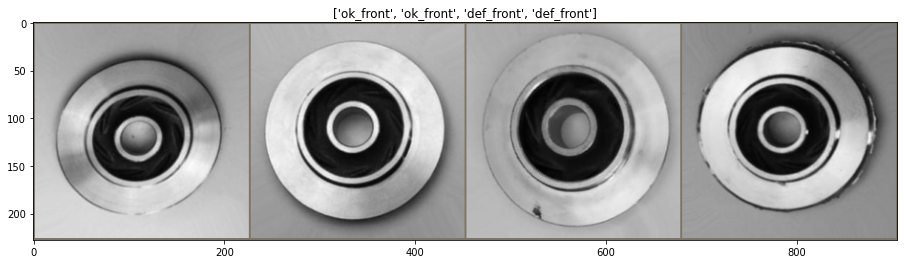

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
plt.figure(figsize=(16, 4))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Transfer-learning
----------------------
Load a pretrained model and reset final fully connected layer.<br>
Train that new classification head while freezing all pre-trained layers.




In [8]:
# load pre-trained backbone 
model_ft = models.vgg16(pretrained=True)

# replace classification head
num_ftrs = model_ft.classifier[6].in_features 
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names), bias=True)

# use cuda if available
model_ft = model_ft.to(device)

# choose loss function
criterion = nn.CrossEntropyLoss()

# freeze all layers except the new one
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.classifier[6].parameters():
    param.requires_grad = True

# choose optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
# model summary
summary(model_ft, torch.ones((1, 3, 224, 224)))

C:\Users\mehdi\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.9626 Acc: 0.7846
val Loss: 0.8319 Acc: 0.7860

Epoch 1/9
----------
train Loss: 1.0542 Acc: 0.8084
val Loss: 1.1521 Acc: 0.7678

Epoch 2/9
----------
train Loss: 0.9676 Acc: 0.8227
val Loss: 0.3043 Acc: 0.8965

Epoch 3/9
----------
train Loss: 0.9057 Acc: 0.8370
val Loss: 0.1931 Acc: 0.9413

Epoch 4/9
----------
train Loss: 0.9508 Acc: 0.8363
val Loss: 0.1687 Acc: 0.9385

Epoch 5/9
----------
train Loss: 0.9754 Acc: 0.8340
val Loss: 1.6922 Acc: 0.6979

Epoch 6/9
----------
train Loss: 0.9101 Acc: 0.8441
val Loss: 0.1413 Acc: 0.9538

Epoch 7/9
----------
train Loss: 0.6636 Acc: 0.8651
val Loss: 0.1385 Acc: 0.9455

Epoch 8/9
----------
train Loss: 0.5955 Acc: 0.8699
val Loss: 0.2547 Acc: 0.9161

Epoch 9/9
----------
train Loss: 0.5161 Acc: 0.8806
val Loss: 0.1427 Acc: 0.9469

Training complete in 20m 6s
Best val Acc: 0.953846


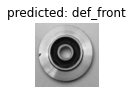

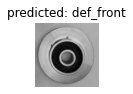

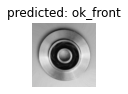

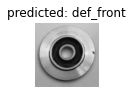

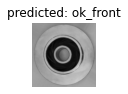

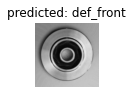

In [11]:
visualize_model(model_ft)

Fine-tuning
----------------------------------

Here, we will unfreze some of the modle layers (including pre-trained ones) and fine-tune them in order to improve the performance of the model.




In [12]:
model_ft.features[26:]

Sequential(
  (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (27): ReLU(inplace=True)
  (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (29): ReLU(inplace=True)
  (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [13]:
for param in model_ft.parameters():
    param.requires_grad = False

features_finetune_from = 26
for param in model_ft.features[features_finetune_from:].parameters():
    param.requires_grad = True

for param in model_ft.classifier.parameters():
    param.requires_grad = False

summary(model_ft, torch.ones((1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [14]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.75 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.75)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [15]:
model_ft = train_model(model_ft, criterion, optimizer_conv,  exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1703 Acc: 0.9495
val Loss: 0.0340 Acc: 0.9902

Epoch 1/4
----------
train Loss: 0.0390 Acc: 0.9878
val Loss: 0.0306 Acc: 0.9888

Epoch 2/4
----------
train Loss: 0.0282 Acc: 0.9922
val Loss: 0.0227 Acc: 0.9916

Epoch 3/4
----------
train Loss: 0.0217 Acc: 0.9938
val Loss: 0.0229 Acc: 0.9930

Epoch 4/4
----------
train Loss: 0.0182 Acc: 0.9950
val Loss: 0.0186 Acc: 0.9916

Training complete in 11m 11s
Best val Acc: 0.993007


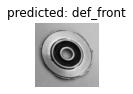

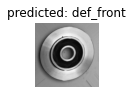

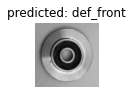

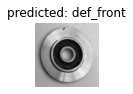

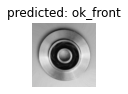

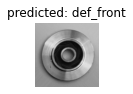

In [16]:
visualize_model(model_ft)

# plt.ioff()
plt.show()

Model Explainability
-----------------


In [111]:
from captum.attr import IntegratedGradients, GuidedGradCam, LayerGradCam
# from captum.attr.visualization import visualize_image_attr
from torchvision.io import read_image
from PIL import Image
import cv2

In [104]:
# model = model_ft

# # defining model input tensors
# input1 = torch.tensor([3.0], requires_grad=True)
# input2 = torch.tensor([1.0], requires_grad=True)

# # defining baselines for each input tensor
# baseline1 = torch.tensor([0.0])
# baseline2 = torch.tensor([0.0])

# # defining and applying integrated gradients on ToyModel and the
# ig = IntegratedGradients(model)
# attributions, approximation_error = ig.attribute((input1, input2),
#                                                  baselines=(baseline1, baseline2),
#                                                  method='gausslegendre',
#                                                  return_convergence_delta=True)
# output

# ...................

# attributions: (tensor([1.5000], grad_fn=<MulBackward0>),
#                tensor([-0.5000], grad_fn=<MulBackward0>))

# approximation_error (aka delta): 1.1801719665527344e-05

In [145]:
net.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [170]:
net.features[21]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

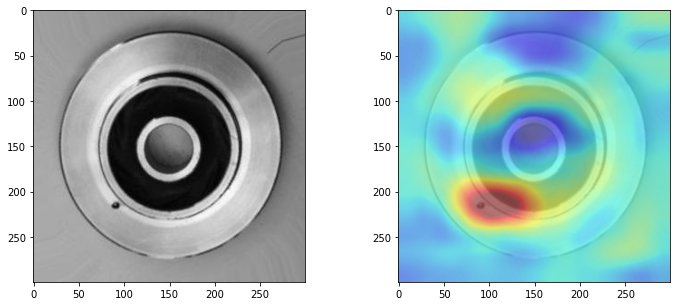

In [244]:
# ImageClassifier takes a single input tensor of images Nx3x32x32,
# and returns an Nx10 tensor of class probabilities.
# It contains an attribute conv4, which is an instance of nn.conv2d,
# and the output of this layer has dimensions Nx50x8x8.
# It is the last convolution layer, which is the recommended
# use case for GuidedGradCAM.
net = model_ft

# guided_gc = GuidedGradCam(net, net.features[28])
guided_gc = LayerGradCam(net, net.features[27])


foldername = os.path.join(data_dir, 'val/' + class_names[0])
imagename = np.random.choice(os.listdir(foldername), 1)[0]

img = Image.open(os.path.join(foldername, imagename))
im = np.asarray(img)

img = data_transforms['val'](img)

input = img.reshape((1,)+img.shape)
input = input.to(device)
input.requires_grad = True


# Computes guided GradCAM attributions for class 3.
# attribution size matches input size, Nx3x32x32
attribution = guided_gc.attribute(input, 0)


grid = attribution.cpu().detach().numpy()[0,:,:,:].transpose((1,2,0))
grid = 255 * ( (grid -  grid.min()) / (grid.max() -  grid.min()) )
grid = grid.astype(np.uint8)
grid = cv2.resize(grid, (300, 300), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.imshow(im)

plt.subplot(1,2,2)
plt.imshow(im, alpha=0.5)
plt.imshow(grid, alpha=0.5, cmap='jet')
